# Iterative Phase Estimation

This tutorial shows the IPE algorithm applied to a simple problem, estimating the eigenvalue of the |11> state for the CT gate, i.e. diag(1, 1, 1, e^ipi/4). This means PHI=pi/4 and phi=1/8=0.001 in bynary, so it can be represented exactly with m=3 classical bits. For an accurate description of the algorithm see https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/algorithms/iterative_phase_estimation_algorithm.ipynb

In [8]:
from math import pi
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
from qiskit_ibm_runtime import QiskitRuntimeService

In [2]:
def get_qc_characteristics(qc):
    depth = qc.depth()
    num_qubits = qc.num_qubits
    ops = qc.count_ops()
    num_multi_qubit_ops = qc.num_nonlocal_gates()
    d = {"depth":depth, "num_qubits":num_qubits, "ops":ops, "num_multi_qubit_ops": num_multi_qubit_ops}
    print(d)

### Step 1: Map problem to quantum circuits and operators

In [3]:
nq = 3    # number of qubits
m = 3    # number of classical bits

PHI = pi/4

q = QuantumRegister(nq,'q')
c = ClassicalRegister(m,'c')

qc = QuantumCircuit(q,c)

qc.h(0)
qc.x([1, 2])

In [4]:
def x_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)

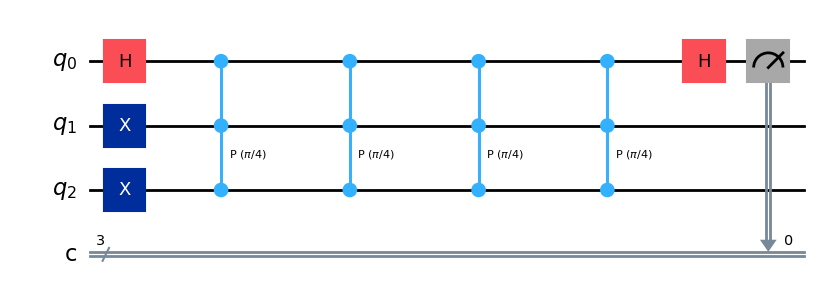

In [5]:
# step 1

for _ in range(2 ** (m - 1)):
    qc.mcp(PHI, [0, 1], 2)

x_measurement(qc, q[0], c[0])
qc.draw('mpl')

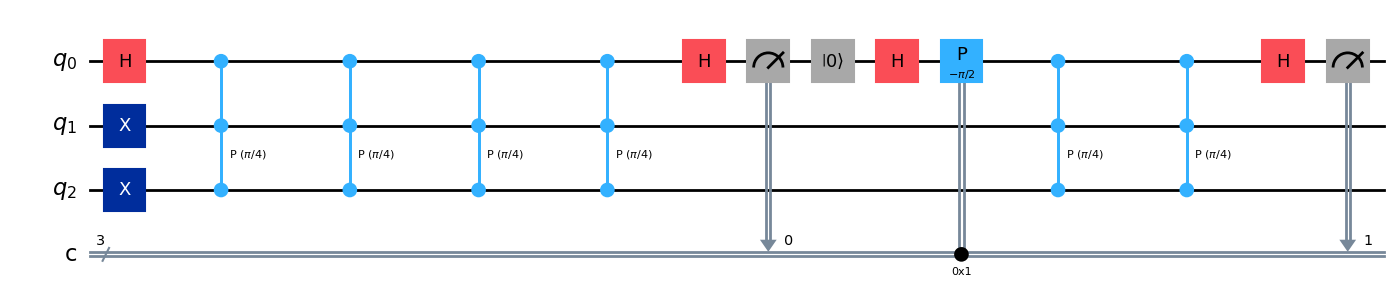

In [6]:
# step 2

qc.reset(0)
qc.h(0)

qc.p(-pi/2, 0).c_if(c, 1) # phase correction

for _ in range(2 ** (m - 2)):
    qc.mcp(PHI, [0, 1], 2)
    
x_measurement(qc, q[0], c[1])
qc.draw('mpl')

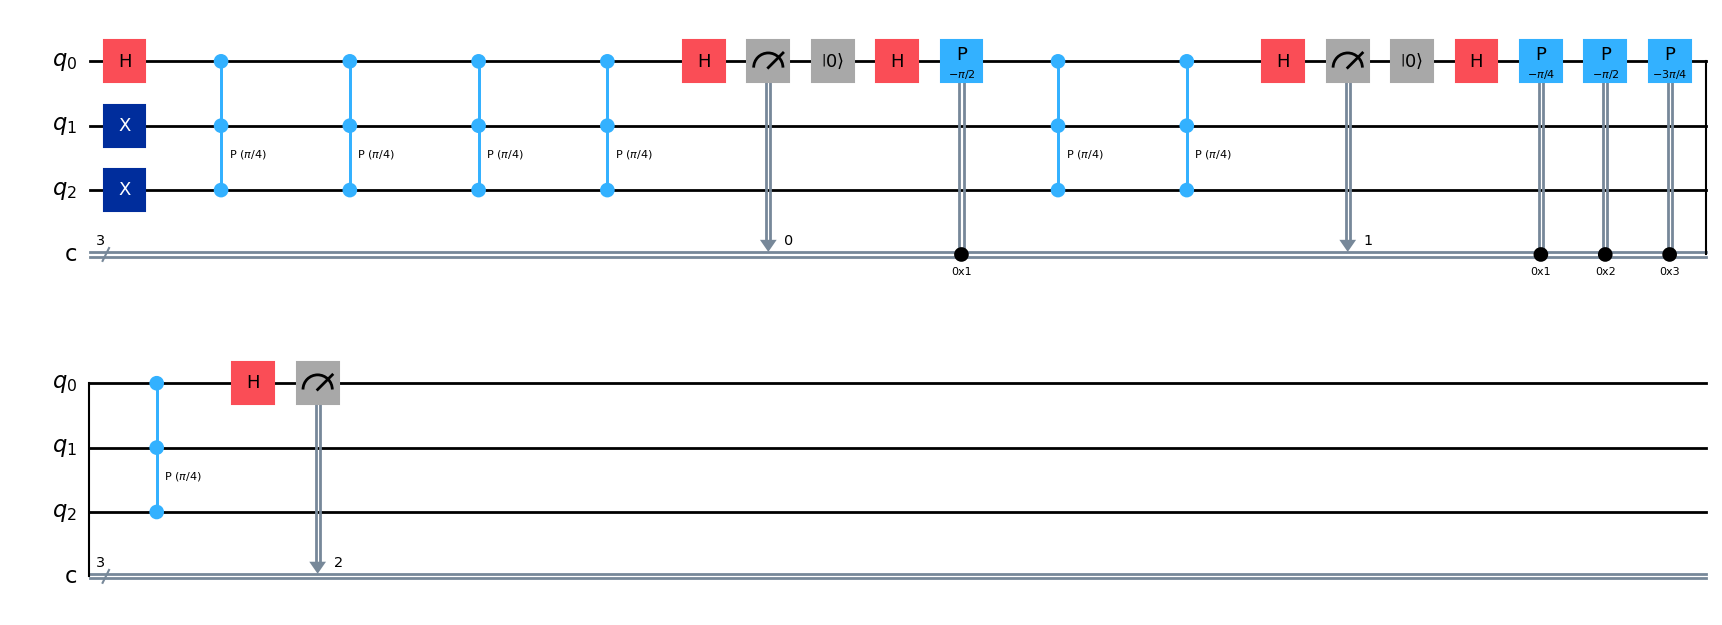

In [7]:
# step 3

qc.reset(0)
qc.h(0)

# phase correction
qc.p(-pi/4, 0).c_if(c, 1) # i.e. c = 01
qc.p(-pi/2, 0).c_if(c, 2) # # i.e. c = 10
qc.p(-3*pi/4, 0).c_if(c, 3) # i.e. c = 11

# c-U operations
for _ in range(2 ** (m - 3)):
    qc.mcp(PHI, [0, 1], 2)

# X measurement  
qc.h(0)
qc.measure(0, 2)

qc.draw('mpl')

### Step 2: Optimize for target hardware

Option 1: fake backend

In [9]:
backend = FakeBrisbane()
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

isa_circuit = pm.run(qc)
get_qc_characteristics(isa_circuit)

{'depth': 336, 'num_qubits': 127, 'ops': OrderedDict([('rz', 329), ('sx', 212), ('ecr', 67), ('x', 5), ('measure', 3), ('reset', 2)]), 'num_multi_qubit_ops': 67}


Option 2: real hardware

In [ ]:
"""
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

isa_circuit = pm.run(qc)
get_qc_characteristics(isa_circuit)
"""

### Step 3: Execute on target hardware (or fake hardware)

In [10]:
sampler = Sampler(mode=backend)
#sampler.options.twirling.enable_gates = True
#sampler.options.twirling.enable_measure = True

result = sampler.run([isa_circuit]).result()

### Step 4: Post-process results

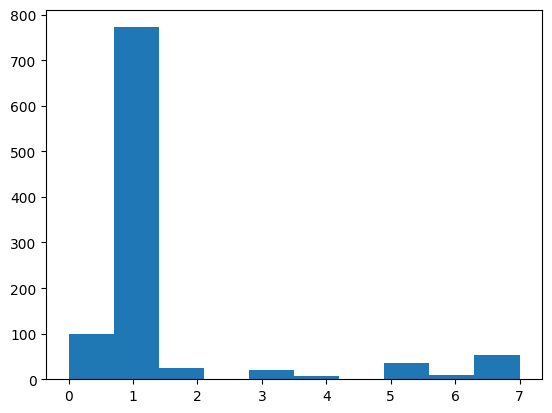

In [11]:
data = result[0].data.c.array
data = np.reshape(data, (data.shape[0]))
freqs, edges, _ = plt.hist(data)

In [12]:
phi_8 = np.argmax(np.bincount(data))
print(f'phi = {phi_8 / 8}')

phi = 0.125
